<h1> Segmenting and Clustering Neighborhoods in Toronto</h1>

Course: Applied Data Science Capstone  
Date of creation: December 23, 2019  
Author: Hyunmyung Myung 

## 1. Preparatory

In [1]:
#Import requisite libraries
import pandas as pd
import numpy as np
import folium
import requests
from bs4 import BeautifulSoup

#Display entire dataframes without omission
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Data Acquisition

In [2]:
#Retrieve the wikipedia page using Beautiful Soup
wiki_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(wiki_url,'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XfMJbApAAEYAAJLDfA8AAABM","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":930529633,"wgRevisionId":930529633,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communi

The table of interest is under table class="wikitable sortable" of the Wikipedia soup. In the below cell, the relevant portion of data is extracted.

In [3]:
#Locate CSS class with "soup.find("tagName", { "class" : "cssClass" })"
main_data = soup.find('table',{'class':'wikitable sortable'})

#Extract discrete items from the above variable
filtered_data = main_data.findAll('td')
filtered_data

[<td>M1A</td>, <td>Not assigned</td>, <td>Not assigned
 </td>, <td>M2A</td>, <td>Not assigned</td>, <td>Not assigned
 </td>, <td>M3A</td>, <td><a href="/wiki/North_York" title="North York">North York</a></td>, <td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
 </td>, <td>M4A</td>, <td><a href="/wiki/North_York" title="North York">North York</a></td>, <td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
 </td>, <td>M5A</td>, <td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>, <td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
 </td>, <td>M6A</td>, <td><a href="/wiki/North_York" title="North York">North York</a></td>, <td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
 </td>, <td>M6A</td>, <td><a href="/wiki/North_York" title="North York">North York</a></td>, <td><a href="/wiki/Lawrence_Manor" title="Lawrence Manor">Lawrence Manor</a>
 </td>, <td>M7A</td>, <td>

In [4]:
#Create an empty dataframe to which the data will be inputted
main_df = pd.DataFrame(columns=['PostalCode','Borough','Neighborhood'])

#Iterate through the soup to generate data for each column
i = 0
postcode,borough,neighborhood = [],[],[] #An empty list variable for each column
replace_keywords = ['<td>','</td>','\n'] #For cleaning up html codes

import re #Module for substring extraction

for item in filtered_data:
    
    #Clean the item content
    try:
        item = re.search('">(.+?)</a>',str(item)).group(1)
    except:
        pass
    finally:
        for keyword in ['<td>','</td>','\n']:
            item = str(item).replace(keyword,'')

    #Append the item to its appropriate column
    if i%main_df.shape[1]==0:
        postcode.append(str(item))
    elif i%main_df.shape[1]==1:
        borough.append(str(item))
    else:
        neighborhood.append(str(item))
    
    #Go to the next item in filtered_data
    i += 1

In the below cell, a dataframe will be based as to satisfy the below conditions:
> 1. The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
> 2. Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
> 3. More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
> 4. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
> 5. In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [5]:
#1: Create a dataframe with 3 columns and appropriate data
main_df['PostalCode'],main_df['Borough'],main_df['Neighborhood'] = postcode,borough,neighborhood

#2: Drop rows with no assigned boroughs
main_df = main_df[main_df['Borough']!='Not assigned']

#3: Combine neighborhoods of duplicate postal codes
main_df = pd.DataFrame(main_df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: "%s" % ', '.join(x)))

#4: Equate the unassigned neighborhoods to their boroughs
main_df.reset_index(inplace = True)

for i in np.arange(main_df.shape[0]):
    if main_df.iloc[i,2]=='Not assigned':
        main_df.iloc[i,2] = str(main_df.iloc[i,1])

#5: Shape
main_df.shape

(103, 3)

Geocoder did not work after several attempts, so the below cell uses the csv file provided by the course to bring in the coordinate of each postal code.

In [6]:
#Import csv file and set index
coordinates_df = pd.read_csv('Geospatial_Coordinates.csv')
coordinates_df.set_index('Postal Code', inplace=True) 

latitudes = []
longitudes = []

#Import coordinate data to the dataframe
for i in np.arange(main_df.shape[0]):
    latitudes.append(coordinates_df.loc[main_df.iloc[i,0],'Latitude'])
    longitudes.append(coordinates_df.loc[main_df.iloc[i,0],'Longitude'])

main_df['Latitude'] = latitudes
main_df['Longitude'] = longitudes

#Display the processed dataframe
main_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


The above dataframe is visualized below.

In [7]:
#Folium map of Toronto (location coordinates were searched online)
toronto_map = folium.Map(location=[43.7,-79.4],zoom_start=11)

#Add markers to map
for latitude,longitude,borough,neighborhood in zip(main_df['Latitude'],main_df['Longitude'],main_df['Borough'],main_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=2,
        popup=label,
        color='gray',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=False).add_to(toronto_map)  

#Display map
toronto_map

Foursquare

In [8]:
CLIENT_ID = 'PJUMQQ5B5QKLY0CO4WPTNUBFZ1HSCD2Q3ABBQUNVUGJGXDWJ' #Foursquare ID (free version)
CLIENT_SECRET = '4H0UOPKIRU4AIKEXBWPNXGICM331G4CYRSNO2WDNRFO4JLGP' #Foursquare Secret (free version)
VERSION = '20180605' #Foursquare API version

LIMIT = 100 #An arbitrary number to avoid using up calls

def getNearbyVenues(names,latitudes,longitudes,radius=500):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        #Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        #Get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
#Use the above custom function to request info for nearby venues from Foursquare
main_df_venues = getNearbyVenues(names=main_df['Neighborhood'],
                                   latitudes=main_df['Latitude'],
                                   longitudes=main_df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [11]:
#A snippet of the Foursquare data
main_df_venues.head(3)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar


The column "Venue_Category" already has a class named "Neighborhood", so the existing column "Neighborhood" has been renamed as "Location" to avoid overwriting.

In [12]:
#One hot encoding
main_df_onehot = pd.get_dummies(main_df_venues[['Venue Category']],prefix="",prefix_sep="")
onehot_column_list = list(main_df_onehot.columns)

#Add neighborhood column back to dataframe
main_df_onehot['Location'] = main_df_venues['Neighborhood'] 

#Move neighborhood column to the first column
rearranged_columns = ['Location'] + onehot_column_list
main_df_onehot = main_df_onehot[rearranged_columns]

#Reset index
main_df_grouped = main_df_onehot.groupby('Location').mean().reset_index()

#Review the result
main_df_grouped.head(3)

,Location,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.01,0.0,0.03,0.0,0.0,0.0,0

The postal codes are clustered below using K means. An iteration is used to find an optimal k value.

In [13]:
from sklearn.cluster import KMeans

main_df_grouped_cluster = main_df_grouped.drop('Location',1)
k_means_test = {} #Empty dictionary

#Set number of clusters (3 to 9)
for k_value in np.arange(2,10):
    k_means = KMeans(n_clusters=k_value).fit(main_df_grouped_cluster) #Run k-means clustering
    k_means_test.update({k_value:k_means.inertia_}) #Attach the k value and its evaluative metric (inertia) to the dictionary

k_means_df = pd.DataFrame.from_dict(k_means_test, orient='index', dtype=float, columns=['Inertia'])
k_means_df.index.name = 'Cluster #'
k_means_df.sort_values(by='Inertia',ascending=True,axis=0,inplace=True)

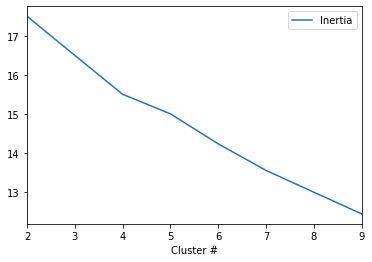

In [14]:
#Visualize the results from the iteration
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

k_means_df.reset_index(inplace=True)
k_means_df.plot(x='Cluster #',y='Inertia')

As expected, the inertia value (i.e. the sum of the squared distances) tends to decrease with increasing k values or the prescribed number of clusters. Having too many clusters will make it difficult to evaluate the properties of each cluster, while too few will return overly generalized clusters.


In the above graph, the slope of the line become less steep between k value 6 and 7, meaning that the benefit of increasing the k value decreases around that interval. Therefore, the k value 6 is used to train the k means model.

In [15]:
#Train the model with k=6
k_means = KMeans(n_clusters=6).fit(main_df_grouped_cluster)

The custom function for returning most common venue categories is brought from the course. This information will be used to evaluate the properties of each cluster.

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

#Create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Location'] = main_df_grouped['Location']

for ind in np.arange(main_df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(main_df_grouped.iloc[ind, :], num_top_venues)

#Add cluster labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_means.labels_)

#Add latitude/longitude for each neighborhood
main_df_merged = main_df
main_df_merged = main_df_merged.join(neighborhoods_venues_sorted.set_index('Location'), on='Neighborhood')

#Drop NaN values
main_df_merged.dropna(inplace=True)

#Convert the cluster labels to allow for visualizations to follow
main_df_merged[['Cluster Labels']] = main_df_merged[['Cluster Labels']].astype('int')

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as colors

#6 is used to match the number of clusters
x = np.arange(6)
z = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(z)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Create map
map_clusters = folium.Map(location=[43.7,-79.4], zoom_start=11)

#Set a color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(main_df_merged['Latitude'], main_df_merged['Longitude'], main_df_merged['Neighborhood'], main_df_merged['Cluster Labels']):
    if cluster == np.nan:
        cluster = 0  
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

#Display the map
map_clusters

Lastly, the properties of each cluster will be examined as follows.

### Cluster 1: Commercial areas

The dataframe below reveals that the neighborhoods in this cluster mainly contains diverse service-sector businesses such as restaurants, coffee shops, grocery/convenient stores, gas stations, etc. 

In [18]:
main_df_merged.loc[main_df_merged['Cluster Labels'] == 0, main_df_merged.columns[[2,1] + list(range(5, main_df_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland Creek, Rouge Hill, Port Union",Scarborough,0,Golf Course,Bar,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
2,"Guildwood, Morningside, West Hill",Scarborough,0,Electronics Store,Breakfast Spot,Rental Car Location,Mexican Restaurant,Medical Center,Intersection,Pizza Place,Donut Shop,Doner Restaurant,Department Store
3,Woburn,Scarborough,0,Coffee Shop,Korean Restaurant,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Dumpling Restaurant
4,Cedarbrae,Scarborough,0,Fried Chicken Joint,Gas Station,Bank,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Bakery,Hakka Restaurant,Lounge,Dumpling Restaurant
6,"East Birchmount Park, Ionview, Kennedy Park",Scarborough,0,Discount Store,Department Store,Coffee Shop,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant,Yoga Studio
7,"Clairlea, Golden Mile, Oakridge",Scarborough,0,Bus Line,Soccer Field,Intersection,Park,Bakery,Fast Food Restaurant,Metro Station,Diner,Discount Store,Dog Run
8,"Cliffcrest, Cliffside, Scarborough Village West",Scarborough,0,American Restaurant,Motel,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio
9,"Birch Cliff, Cliffside West",Scarborough,0,College Stadium,Café,Skating Rink,General Entertainment,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
10,"Dorset Park, Scarborough Town Centre, Wexford ...",Scarborough,0,Indian Restaurant,Brewery,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
11,"Maryvale, Wexford",Scarborough,0,Middle Eastern Restaurant,Auto Garage,Breakfast Spot,Shopping Mall,Bakery,Sandwich Place,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner


### Cluster 2: Nature within city

The common venues indicate that these neighborhoods have more nature-leisure areas (e.g. parks, playgrounds, trails) and are less crowded than cluster 1.

In [19]:
main_df_merged.loc[main_df_merged['Cluster Labels'] == 1, main_df_merged.columns[[2,1] + list(range(5, main_df_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,Humber Summit,North York,1,Pizza Place,Empanada Restaurant,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore


### Cluster 3: Residential areas

This cluster seems similar to cluster 1, but the venues seem to be of categories that serve local residential populations, such as pharmacy, pet store, pub, and bank.

In [20]:
main_df_merged.loc[main_df_merged['Cluster Labels'] == 2, main_df_merged.columns[[2,1] + list(range(5, main_df_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Silver Hills, York Mills",North York,2,Cafeteria,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Yoga Studio,Deli / Bodega


### Cluster 4: Athletes' Den

Thee neighborhoods have pool, basedball field, and yoga studio as their 3 most common venue categories.

In [21]:
main_df_merged.loc[main_df_merged['Cluster Labels'] == 3, main_df_merged.columns[[2,1] + list(range(5, main_df_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough Village,Scarborough,3,Convenience Store,Playground,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
14,"Agincourt North, L'Amoreaux East, Milliken, St...",Scarborough,3,Park,Playground,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
48,"Moore Park, Summerhill East",Central Toronto,3,Tennis Court,Playground,Yoga Studio,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


### Cluster 5: York University

The below neighborhood has York University nearby, hence cafeteria as the most common venue category.

In [22]:
main_df_merged.loc[main_df_merged['Cluster Labels'] == 4, main_df_merged.columns[[2,1] + list(range(5, main_df_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,York Mills West,North York,4,Park,Convenience Store,Bank,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Department Store
25,Parkwoods,North York,4,Construction & Landscaping,Park,Food & Drink Shop,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Yoga Studio
30,"CFB Toronto, Downsview East",North York,4,Park,Airport,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
40,East Toronto,East York,4,Park,Convenience Store,Metro Station,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
44,Lawrence Park,Central Toronto,4,Park,Bus Line,Swim School,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Deli / Bodega
50,Rosedale,Downtown Toronto,4,Park,Trail,Playground,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
64,"Forest Hill North, Forest Hill West",Central Toronto,4,Trail,Park,Jewelry Store,Sushi Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
74,Caledonia-Fairbanks,York,4,Park,Women's Store,Fast Food Restaurant,Market,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
79,"Downsview, North Park, Upwood Park",North York,4,Park,Bakery,Construction & Landscaping,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store,Donut Shop
90,"The Kingsway, Montgomery Road, Old Mill North",Etobicoke,4,River,Pool,Park,College Rec Center,College Stadium,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore


### Cluster 6: Nightlife
Because bar is the most common venue category.

In [23]:
main_df_merged.loc[main_df_merged['Cluster Labels'] == 5, main_df_merged.columns[[2,1] + list(range(5, main_df_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge, Malvern",Scarborough,5,Fast Food Restaurant,Yoga Studio,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
